# DATA200 Final Project
**Kira Rohra, Jamie Beatty, Carolyn Nguyen**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

## Research Question
Analyzing the factors attributed to unaffordability.

# Classification

## Cleaning

In [2]:
difficulty=pd.read_csv("Difficulty2.csv")
difficulty=difficulty.drop(np.arange(0,8))
difficulty=difficulty.drop(np.arange(190,223))
difficulty=difficulty.drop(difficulty.columns[0],axis=1)
difficulty.rename(columns=dict(zip(difficulty.columns, difficulty.loc[8])), inplace=True)
difficulty=difficulty.drop([8,9])
difficulty=difficulty.reset_index().drop("index",axis=1)
difficulty=difficulty.fillna(method="ffill")
difficulty=difficulty.rename(columns={difficulty.columns[4]:"Percentage"})
difficulty=difficulty.drop("Reference period",axis=1)
total_groups=difficulty[difficulty.columns[1]].unique()
age_group=total_groups[1:5]
total_groups
age=difficulty[difficulty["Sociodemographic characteristics"].isin(age_group)].reset_index().drop("index",axis=1)


### Creating a New Dataframe with parameters & predictions

In [3]:
age_classes=age.iloc[age.groupby(["Gender","Sociodemographic characteristics"])["Percentage"].idxmax()]
age_classes_encoded = pd.get_dummies(age_classes, columns=['Gender', 'Sociodemographic characteristics'])
X = age_classes_encoded.drop(columns=['Indicators',"Percentage"])
y = age_classes_encoded['Indicators']
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X, y);
age_classes_encoded.head()

,Indicators,Percentage,Gender_Men,Gender_Women,Sociodemographic characteristics_15 to 24 years,Sociodemographic characteristics_25 to 54 years,Sociodemographic characteristics_55 to 64 years,Sociodemographic characteristics_65 years and over
2,Easy or very easy for household to meet financ...,40.5,True,False,True,False,False,False
3,Very difficult or difficult for household to m...,39.3,True,False,False,True,False,False
7,Neither difficult nor easy for household to me...,36.7,True,False,False,False,True,False
11,Easy or very easy for household to meet financ...,39.3,True,False,False,False,False,True
14,Easy or very easy for household to meet financ...,37.7,False,True,True,False,False,False


Based on this data, there is not a big difference between Genders, but a lot of difference between ages. Ages 15-24 find it easy or very easy for their household to meet financial needs. 25054 seems to find it the hardest, and 55-64 does not find it difficult nor easy. Over 65 seems to find it easy or very easy. It's important to recognise that this data was aggregated before, and does not have individual records due to Statistics Canada. Therefore, this model uses the maximum for each class to predict. Averages do not apply to individuals. Since we do not have individual records, we cannot use cross validation to test accuracy. We will do that elsewhere.

### This is our first classification model predicting based on age & gender.

In [4]:
logistic_regression_model.predict([[True,False,False,False,False,True],
                                   [False,True,False,False,True,False],[True,False,False,True,False,False]])

array(['Easy or very easy for household to meet financial needs 4',
       'Neither difficult nor easy for household to meet financial needs 4',
       'Very difficult or difficult for household to meet financial needs 4'],
      dtype=object)

## Creating another Classification Model based on gender & education level

In [5]:
education_groups = total_groups[21:25]
filtered_df = difficulty[difficulty["Sociodemographic characteristics"].isin(education_groups)]

# Now, group by gender and "Sociodemographic characteristics", and find the row with the maximum percentage within each group
education_classes = filtered_df.loc[filtered_df.groupby(["Gender", "Sociodemographic characteristics"])["Percentage"].idxmax()]
education_classes_encoded = pd.get_dummies(education_classes, columns=['Gender', 'Sociodemographic characteristics'])
X2 = education_classes_encoded.drop(columns=['Indicators',"Percentage",
                                             "Sociodemographic characteristics_Total, highest certificate, diploma or degree"])
y2 = education_classes_encoded['Indicators']
logistic_regression_model2 = LogisticRegression()
logistic_regression_model2.fit(X2, y2);

The above code filters the dataset to focus on certain sociodemographic groups based on education. It then further filters the Dataframe to include only rows where the "Sociodemographic characteristics" match these education groups. After filtering, it groups the data by gender and sociodemographic characteristics, selecting the row with the highest percentage within each group to form the education classes. These classes are then encoded using one-hot encoding to transform categorical variables ('Gender' and 'Sociodemographic characteristics') into numerical. 

In [6]:
logistic_regression_model2.predict([[True,False,True,False,False]])

array(['Neither difficult nor easy for household to meet financial needs 4'],
      dtype=object)

In [7]:
education_classes_encoded.drop("Sociodemographic characteristics_Total, highest certificate, diploma or degree",axis=1).head()

,Indicators,Percentage,Gender_Men,Gender_Women,"Sociodemographic characteristics_No certificate, diploma or degree","Sociodemographic characteristics_Postsecondary certificate, diploma or degree",Sociodemographic characteristics_Secondary (high) school diploma or equivalency certificate
67,Neither difficult nor easy for household to me...,37.6,True,False,True,False,False
73,Neither difficult nor easy for household to me...,34.2,True,False,False,True,False
70,Neither difficult nor easy for household to me...,38,True,False,False,False,True
64,Neither difficult nor easy for household to me...,35.7,True,False,False,False,False
156,Very difficult or difficult for household to m...,36.1,False,True,True,False,False


We used a pre-trained logistic regression model to predict an outcome based on a specific set of Boolean features, indicating the presence or absence of certain characteristics. Following this prediction, it modifies the `education_classes_encoded` DataFrame by removing a specific column related to sociodemographic characteristics concerning education levels. 

# Using CPI as a Measure of Inflation

## Importing Libraries

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

## Cleaning the CPI data

In [9]:
#Use only the all items rows
CPI = pd.read_csv("CPI.csv")
CPI.columns = CPI.iloc[0]
CPI = CPI.drop(CPI.index[[0,1]]).head(1)
CPI.reset_index(drop=True, inplace=True)
CPI = CPI.iloc[:, 1:]
CPI

,Jan-76,Feb-76,Mar-76,Apr-76,May-76,Jun-76,Jul-76,Aug-76,Sep-76,Oct-76,...,Mar-22,Apr-22,May-22,Jun-22,Jul-22,Aug-22,Sep-22,Oct-22,Nov-22,Dec-22
0,30.3,30.5,30.6,30.7,30.9,31.1,31.3,31.3,31.5,31.7,...,148.9,149.8,151.9,152.9,153.1,152.6,152.7,153.8,154,153.1


In [10]:
num_datasets = len(CPI.columns) // 12

# store datasets for each set of 12 columns
datasets_by_set = {}

for i in range(num_datasets):
    start_idx = i * 12
    end_idx = (i + 1) * 12
    dataset_for_set = CPI.iloc[:, start_idx:end_idx]
    datasets_by_set[f"Dataset {i+1}"] = dataset_for_set

In [11]:
for dataset_name, dataset in datasets_by_set.items():
    # Transpose the dataset
    transposed_dataset = dataset.T  # Transpose to make years as rows
    
    # Convert the datatype of rows to numeric
    transposed_dataset = transposed_dataset.apply(pd.to_numeric, errors='coerce')

In [12]:
average_inflation_list = []

for dataset_name, dataset in datasets_by_set.items():
    # Convert the dataset to numeric, ignoring non-numeric values
    dataset_numeric = dataset.apply(pd.to_numeric, errors='coerce')
    average_inflation_rate = dataset_numeric.mean().mean()
    average_inflation_rate = round(average_inflation_rate, 2)

    # append
    average_inflation_list.append((dataset_name, average_inflation_rate))

#print(average_inflation_list)

In [13]:
# Extract years and rounded average inflation rates from the result
years = list(range(1976, 2022 + 1))  # Adjust the range to match the length of inflation_rates
inflation_rates = [round(rate, 2) for _, rate in average_inflation_list]

## Using Cross-Validation to Perform Linear Regression

Average MSE: 54.753810311858125
Regression score on training set: 0.9784234305151553
Regression score on test set: -2.7192284666836186


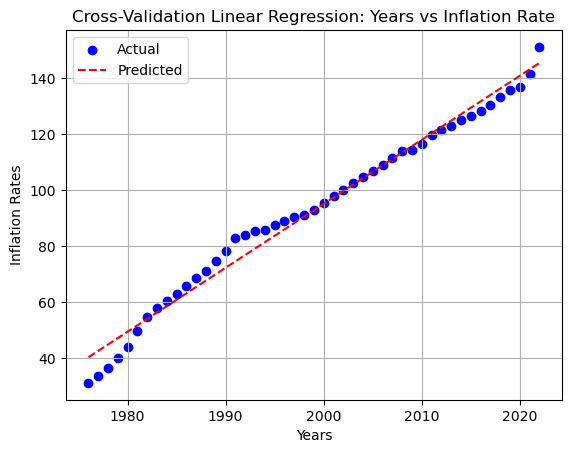

In [14]:
# Define features (years) and target (inflation rates)
X = np.array(years).reshape(-1, 1)
y = np.array(inflation_rates)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize Linear Regression model
model = LinearRegression()

# Perform time series cross-validation
mse_scores = []

# Plot the actual values
plt.scatter(X, y, color='blue', label='Actual')

# Initialize an empty array to store all predicted values
all_predicted_values = np.array([])

#Initialze test and training accuracy array
test_accuracy_array = []
training_accuracy_array = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model on training data
    model.fit(X_train, y_train)

    # Calculate accuracy on training set
    training_accuracy = model.score(X_train, y_train)
    training_accuracy_array.append(training_accuracy)
    
    # Calculate accuracy on test set
    test_accuracy = model.score(X_test, y_test)
    test_accuracy_array.append(test_accuracy)
    
    # Predict on testing data and store the predictions
    y_pred = model.predict(X_test)
    all_predicted_values = np.concatenate((all_predicted_values, y_pred))

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate average MSE across all folds
avg_mse = np.mean(mse_scores)
print("Average MSE:", avg_mse)

#Calculate average model accuracy
avg_test = np.mean(test_accuracy_array)
avg_train = np.mean(training_accuracy_array)
print (f'Regression score on training set: {avg_train}')
print (f'Regression score on test set: {avg_test}')

# Train the model on the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred_all = model.predict(X)

# Plot the model's predictions for the entire dataset
plt.plot(X, y_pred_all, color='red', linestyle='--', label='Predicted')

# Plot formatting
plt.title('Cross-Validation Linear Regression: Years vs Inflation Rate')
plt.xlabel('Years')
plt.ylabel('Inflation Rates')
plt.legend()
plt.grid(True)
plt.show()

You can see the trend of the CPI (how we're measuring inflation), increasing over the years. This is aligned with our view of the world becoming more unaffordable. Inflation is rising, but as we could see with the productivity-pay gap (midterm project), wages aren't rising at the appropriate level. 
Seeing the plot, the model looks to fit the data well, with the predicted values being close to the actual ones. However, looking at the R^2 scores, the model is overfitting. The regression score on the training set is 98% but on the test set it is negative, showing it is overfit. 

## Plotting the Residuals

Text(0.5, 1.0, 'Residual Plot')

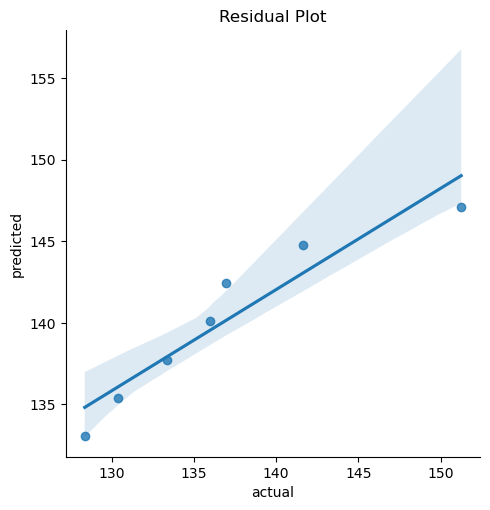

In [16]:
residuals = y_pred - y_test
residual_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'residual': residuals}) 
sns.lmplot(data=residual_df, x = "actual", y = "predicted")
plt.title("Residual Plot")

Looking at the residuals, as the actual values are rising, so are the predicted. The points are close to the line, showing the residuals are small, making it a good model in terms of actual vs predicted values.

## GitHub Links
- https://github.com/JamieBeatty/DATA200Project
- https://github.com/carolyn-1803/DATA200-FinalProject/tree/main
- https://github.com/kiranrohra-afk/DATA200-Final-Project